In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

In [2]:
train_df = pd.read_csv('content/train.csv')
weather_train_df = pd.read_csv('content/weather_train.csv')
building_meta_df = pd.read_csv('content/building_metadata.csv')

# Loading the data

## Merging the data

In [3]:
train_df = train_df.merge(building_meta_df, on="building_id")
train_df = train_df.merge(weather_train_df, on=["site_id", "timestamp"])

In [4]:
train_df.drop(columns=['Unnamed: 0','Unnamed: 0.1'], inplace=True)

In [ ]:
train_df

## reducing size for memory optim

In [5]:
d_types = {'building_id': np.int16,
          'meter': np.int8,
          'site_id': np.int8,
           'floor':np.int8,
           'area': np.int8 ,
          'primary_use': 'category',
          'square_feet': np.int32,
          'year_built': np.float16,
          'floor_count': np.float16,
          'air_temperature': np.float32,
          'cloud_coverage': np.float16,
          'dew_temperature': np.float32,
          'precip_depth_1_hr': np.float16,
          'sea_level_pressure': np.float32,
          'wind_direction': np.float16,
          'wind_speed': np.float32}

for feature in d_types:
    train_df[feature] = train_df[feature].astype(d_types[feature])


## Changing timestamp type  into datetime

In [6]:
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])

## Adding Month and day as new features

In [7]:
train_df['day'] = train_df['timestamp'].dt.day
train_df['month'] = train_df['timestamp'].dt.month
train_df['hour'] = train_df['timestamp'].dt.hour

In [8]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,floor,...,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,day,month,hour
0,105,0,2016-01-01,23.3036,1,Education,50623,0.0,5.0,1,...,3.8,NaN,2.4,NaN,1020.900024,240.0,3.1,1,1,0
1,106,0,2016-01-01,0.3746,1,Education,5374,0.0,4.0,1,...,3.8,NaN,2.4,NaN,1020.900024,240.0,3.1,1,1,0
2,106,3,2016-01-01,0.0000,1,Education,5374,0.0,4.0,1,...,3.8,NaN,2.4,NaN,1020.900024,240.0,3.1,1,1,0
3,107,0,2016-01-01,175.1840,1,Education,97532,2005.0,10.0,2,...,3.8,NaN,2.4,NaN,1020.900024,240.0,3.1,1,1,0
4,108,0,2016-01-01,91.2653,1,Education,81580,1913.0,5.0,1,...,3.8,NaN,2.4,NaN,1020.900024,240.0,3.1,1,1,0


## creating categorical col out of th primary_use col

In [9]:
 # categories are assumed to be the unique values of `values` (sorted, if possible, otherwise in the order in which they appear).
train_df['primary_use'] = pd.Categorical(train_df['primary_use'])
train_df['primary_use'] = train_df['primary_use'].cat.codes

In [10]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,floor,...,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,day,month,hour
0,105,0,2016-01-01,23.3036,1,0,50623,0.0,5.0,1,...,3.8,NaN,2.4,NaN,1020.900024,240.0,3.1,1,1,0
1,106,0,2016-01-01,0.3746,1,0,5374,0.0,4.0,1,...,3.8,NaN,2.4,NaN,1020.900024,240.0,3.1,1,1,0
2,106,3,2016-01-01,0.0000,1,0,5374,0.0,4.0,1,...,3.8,NaN,2.4,NaN,1020.900024,240.0,3.1,1,1,0
3,107,0,2016-01-01,175.1840,1,0,97532,2005.0,10.0,2,...,3.8,NaN,2.4,NaN,1020.900024,240.0,3.1,1,1,0
4,108,0,2016-01-01,91.2653,1,0,81580,1913.0,5.0,1,...,3.8,NaN,2.4,NaN,1020.900024,240.0,3.1,1,1,0


percent of missing values

In [11]:
100 * train_df.isnull().sum() / len(train_df)

building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built             0.000000
floor_count            0.000000
floor                  0.000000
area                   0.000000
air_temperature        0.045029
cloud_coverage        59.128985
dew_temperature        0.081618
precip_depth_1_hr     53.006291
sea_level_pressure    22.936428
wind_direction         2.188237
wind_speed             0.145556
day                    0.000000
month                  0.000000
hour                   0.000000
dtype: float64

## Dropping high missing values col

In [12]:
del train_df['floor_count']
del train_df['year_built']

In [13]:
train_df.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'floor', 'area', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed', 'day', 'month',
       'hour'],
      dtype='object')

# Exploring Data for outliers

## keeping only meter 0 and 1

0: electricity
1: chilled water

In [14]:
train_df.drop(index=train_df[ train_df['meter'] > 1].index, inplace=True )

In [15]:
train_df.meter.unique()

array([0, 1], dtype=int8)

In [16]:
train_df.site_id.unique()

array([ 1,  4,  5,  7,  8, 10, 12], dtype=int8)

## Visualizing mean of energy per site

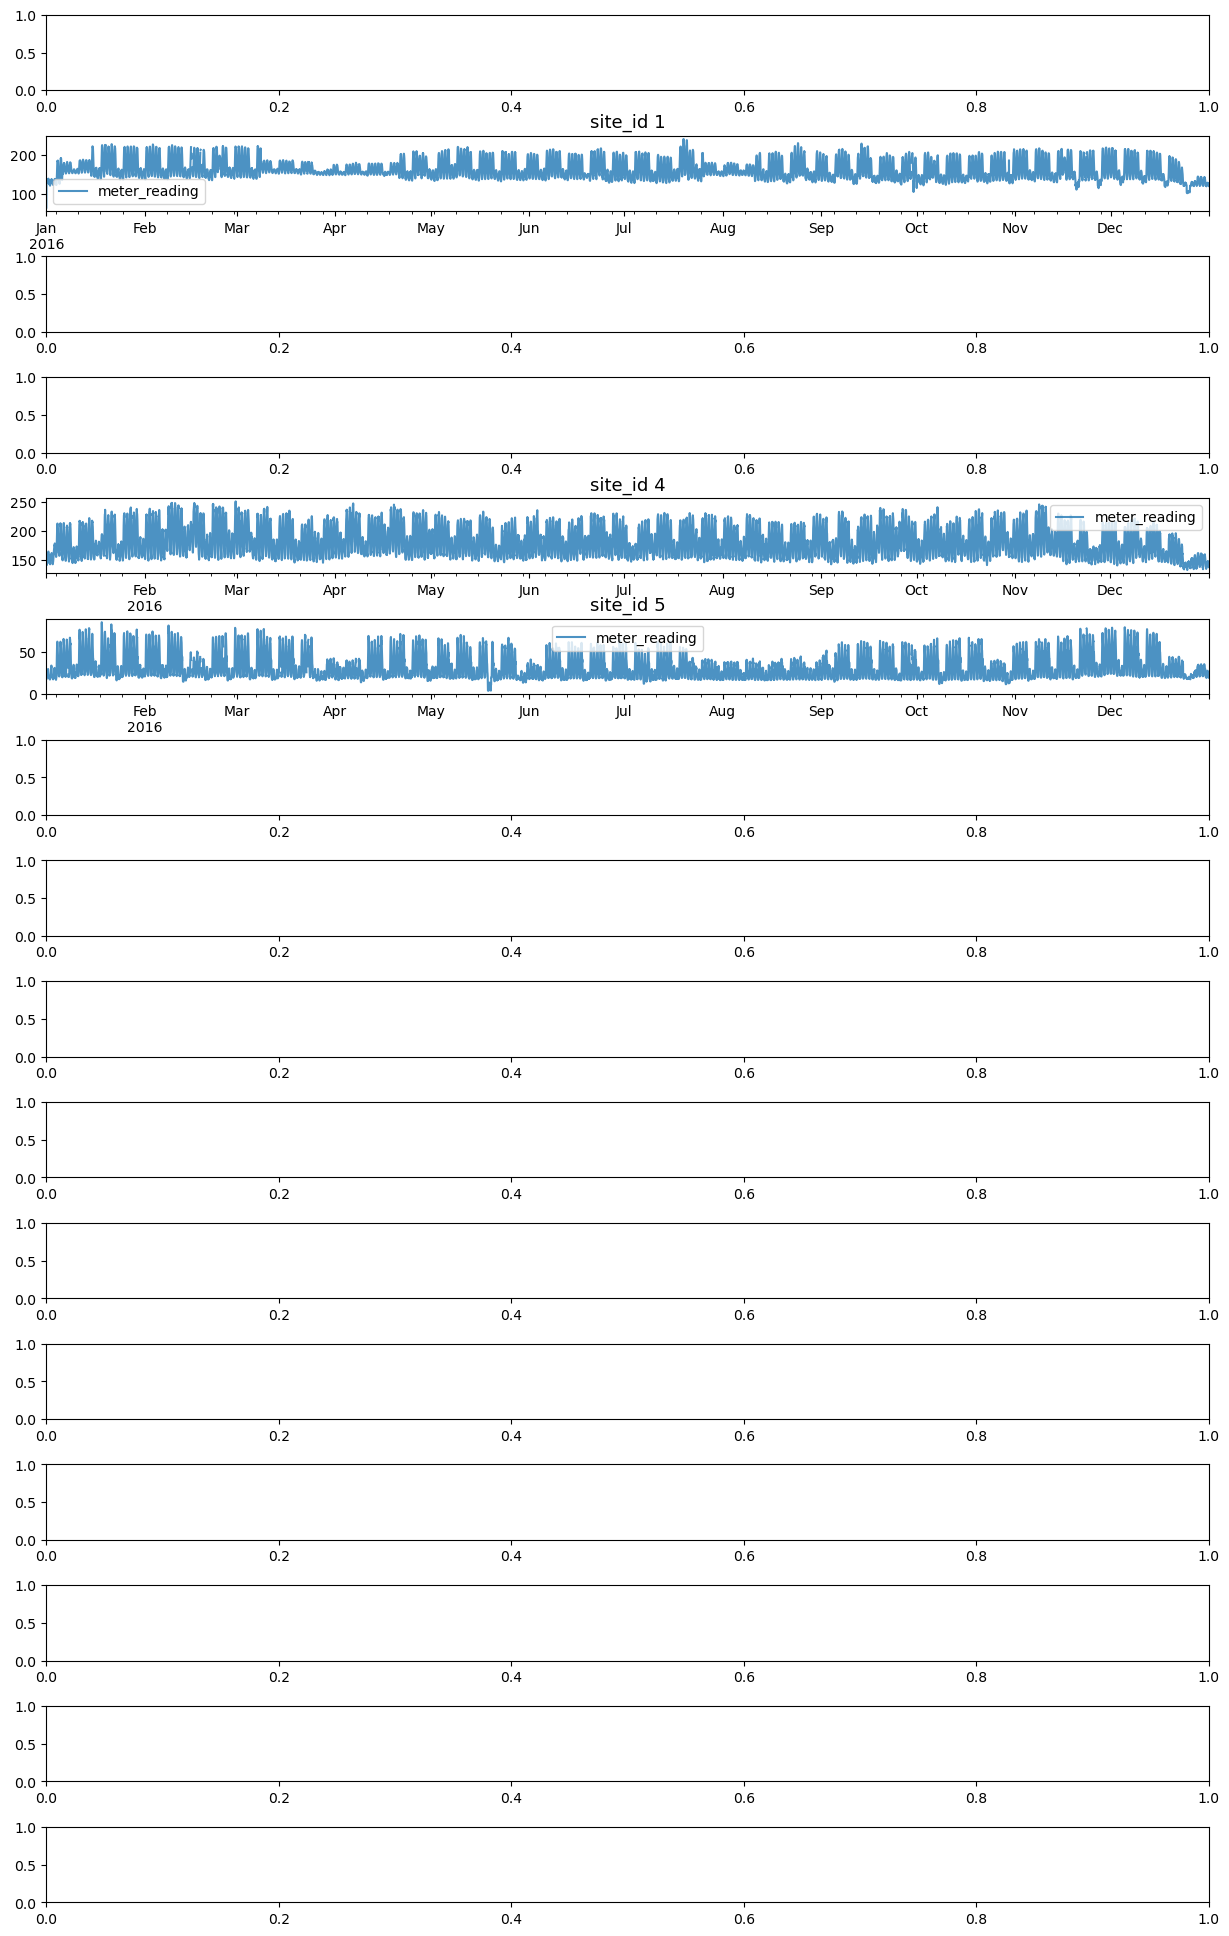

In [17]:
fig, axes = plt.subplots(16,figsize=(15, 25), dpi=100)
for i in range(train_df['site_id'].nunique()):
    try:
        train_df[train_df['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean().plot(ax=axes[i], alpha=0.8, label='By hour')
        axes[i].set_title('site_id {}'.format(i), fontsize=13);
        plt.subplots_adjust(hspace=0.6)
    except: pass

## Checking site 9

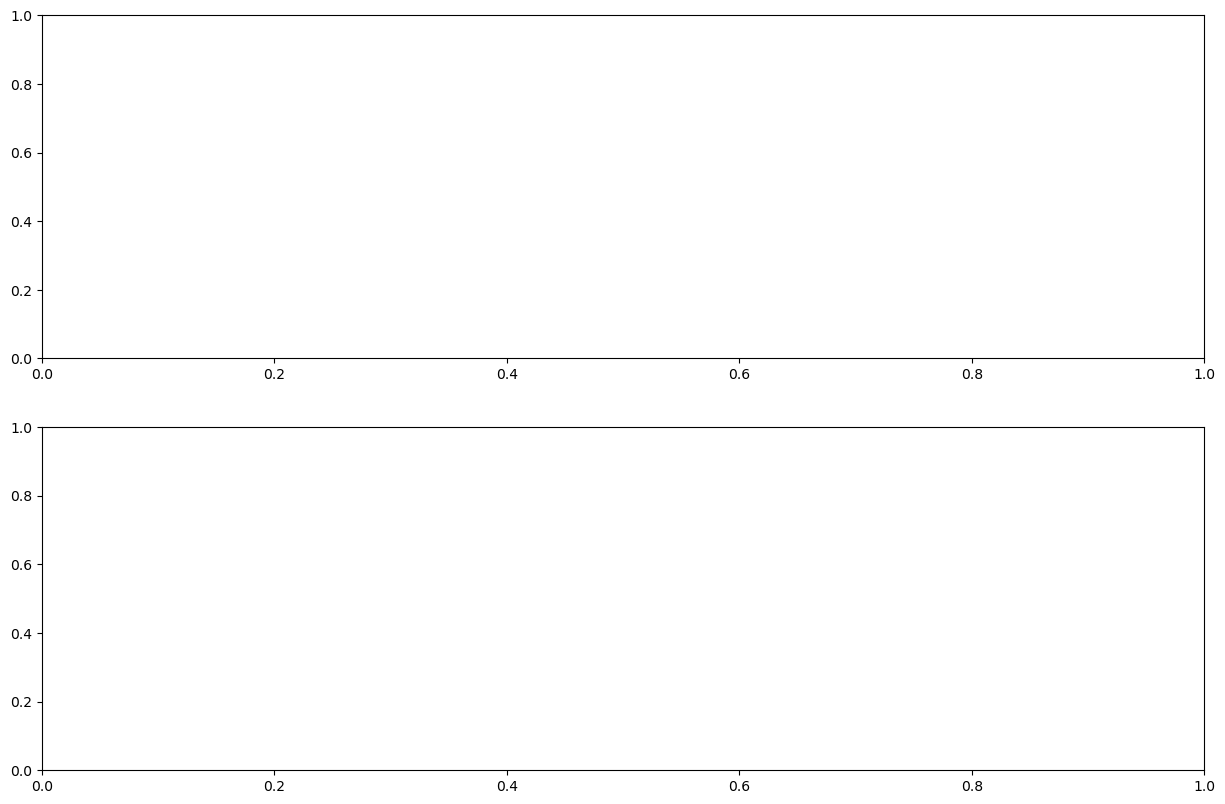

In [18]:
fig, axes = plt.subplots(2,1,figsize=(15, 10), dpi=100)
for i in list( train_df[(train_df['site_id'] == 9)]['meter'].unique() ) :
    train_df[(train_df['site_id'] == 9) & (train_df['meter'] == i)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    axes[i].legend();
    axes[i].set_title('Meter: ' + str(i), fontsize=13);
    plt.subplots_adjust(hspace=0.6)

### we can see clear outliers, lets check if it's a building issue or a certain type or buildings

In [19]:
# train_df[(train_df['site_id'] == 9)]['primary_use'].unique()

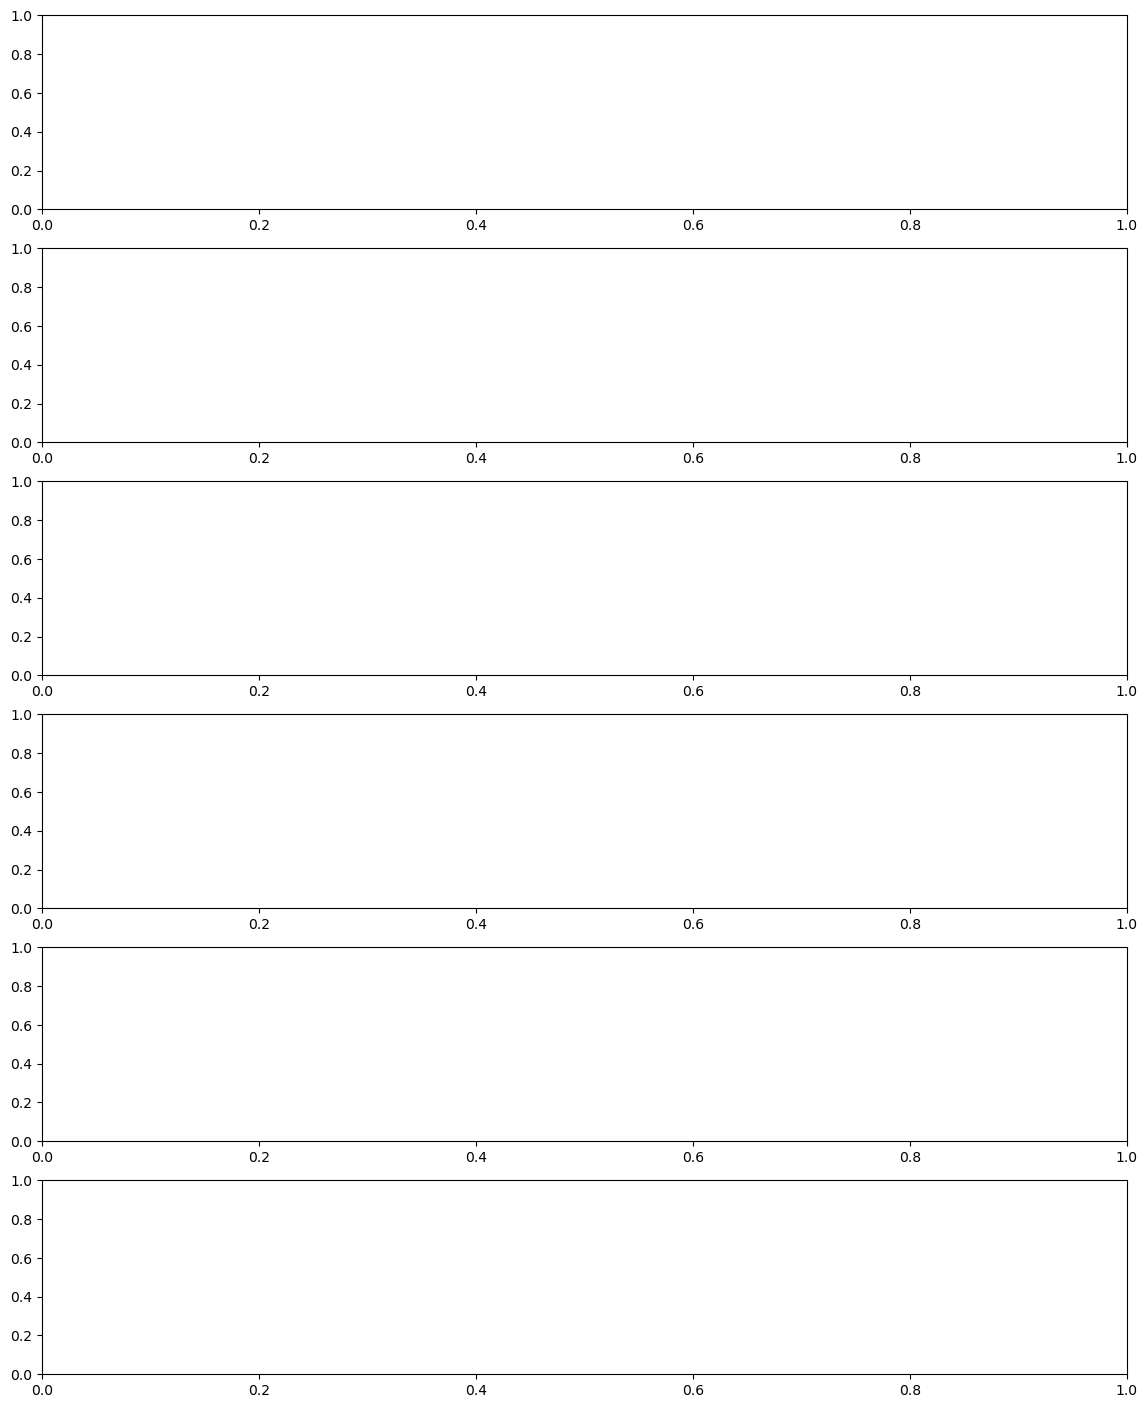

In [20]:
fig, axes = plt.subplots(6,1,figsize=(14, 18), dpi=100)
counter_var=0
for i in list( train_df[(train_df['site_id'] == 9)]['primary_use'].unique() ) :
    train_df[ (train_df['site_id'] == 9) & (train_df['primary_use'] == i) ] [['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[counter_var], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13)
    axes[counter_var].set_title('primary_use: ' + str(i), fontsize=13);
    counter_var+=1
    plt.subplots_adjust(hspace=0.6)

### Clipping values

let's try clipping at 200

In [21]:
clipped_values= train_df[(train_df['site_id'] == 9)].meter_reading.clip( upper=200, axis=0)
clipped_idx= train_df[(train_df['site_id'] == 9)].index
train_df.loc[clipped_idx,'meter_reading']= clipped_values

let's visualize again

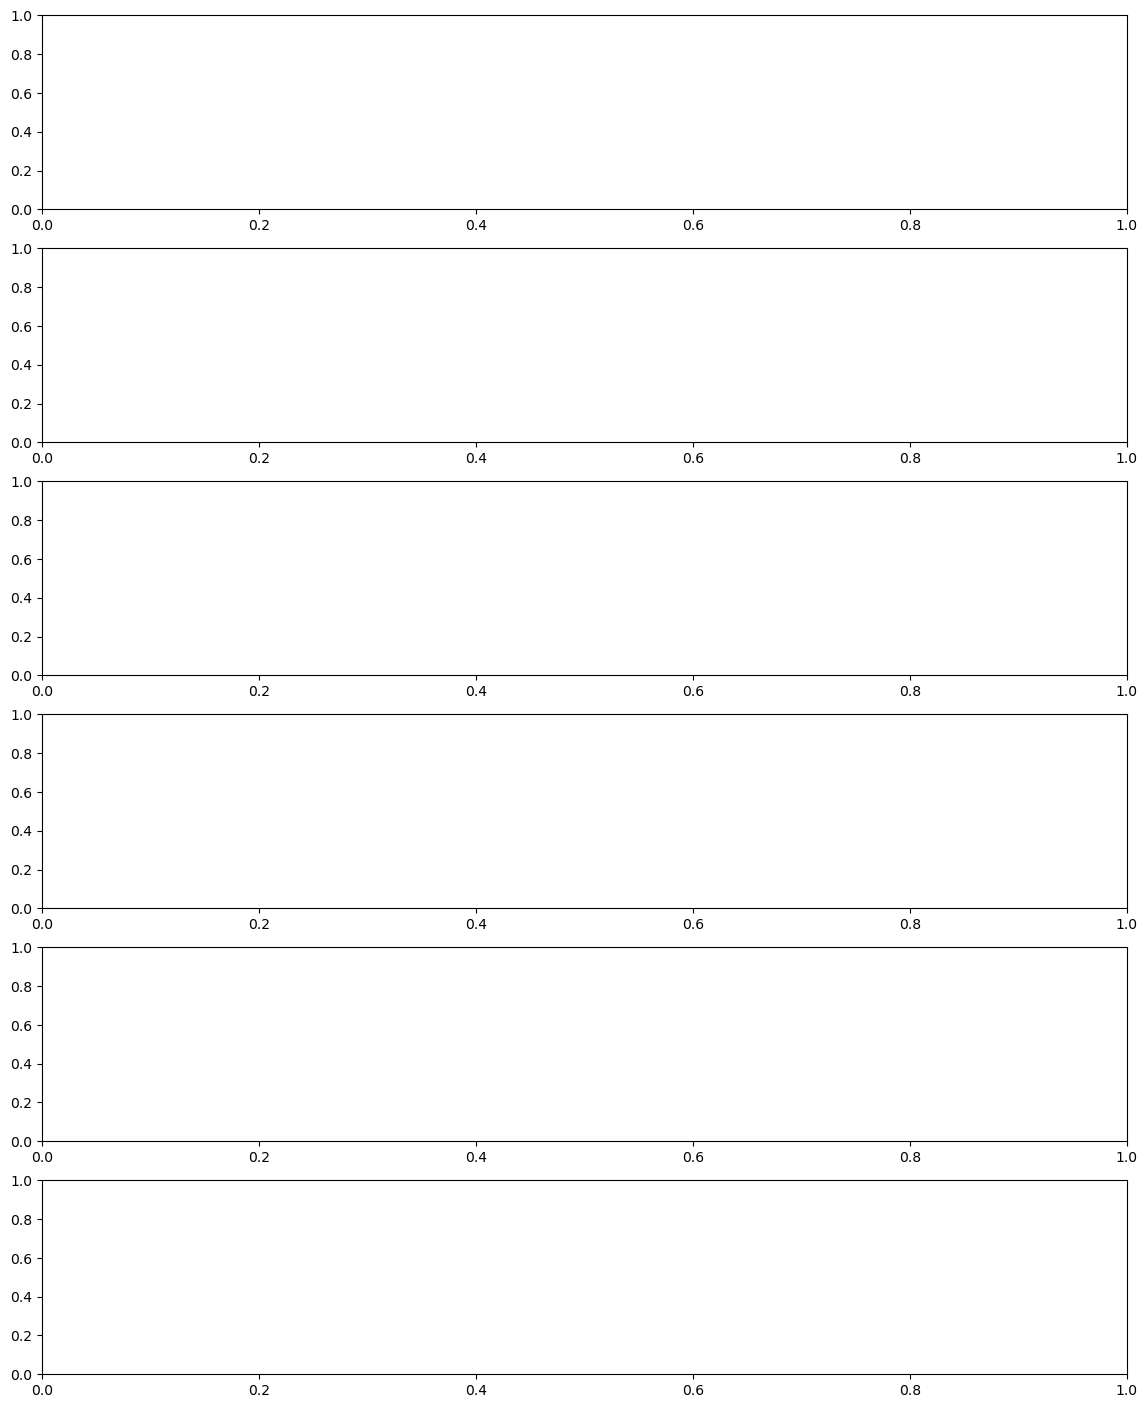

In [22]:
fig, axes = plt.subplots(6,1,figsize=(14, 18), dpi=100)
counter_var=0
for i in list( train_df[(train_df['site_id'] == 9)]['primary_use'].unique() ) :
    train_df[ (train_df['site_id'] == 9) & (train_df['primary_use'] == i) ] [['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[counter_var], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13)
    #train_df[ (train_df['site_id'] == 9) & (train_df['primary_use'] == i) ] [['timestamp', 'meter_reading']].set_index('timestamp').resample('H').var()['meter_reading'].plot(ax=axes[counter_var], alpha=0.8, label='By hour', color='tab:red').set_ylabel('Mean meter reading', fontsize=13)
    axes[counter_var].set_title('primary_use: ' + str(i), fontsize=13);
    counter_var+=1
    plt.subplots_adjust(hspace=0.6)

well that's way better!

### so we decided keep site 9 and clip the values

## Checking site 13

In [23]:
fig, axes = plt.subplots(len(train_df[(train_df['site_id'] == 13)]['primary_use'].unique()),
                         1,figsize=(14, 18), dpi=100)
counter_var=0
for i in list( train_df[(train_df['site_id'] == 13)]['primary_use'].unique() ) :
    train_df[ (train_df['site_id'] == 13) & (train_df['primary_use'] == i) ] [['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[counter_var], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13)
    axes[counter_var].set_title('primary_use: ' + str(i), fontsize=13);
    counter_var+=1
    plt.subplots_adjust(hspace=0.6)

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1400x1800 with 0 Axes>

### so we decided to ditch site13's primary use 0

In [ ]:
train_df.drop(index=train_df[ (train_df['site_id'] == 9) & (train_df['primary_use'] == 0) ].index, inplace=True )

### Showing the effect of dropping the outlier

In [ ]:
fig, axes = plt.subplots(2,1,figsize=(14, 10), dpi=100)
for i in list( train_df[(train_df['site_id'] == 13)]['meter'].unique() ) :
    train_df[(train_df['site_id'] == 13) & (train_df['meter'] == i)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    axes[i].set_title('Meter: ' + str(i), fontsize=13);
    plt.subplots_adjust(hspace=0.6)

### clipping values

In [ ]:
condition= train_df[(train_df['site_id'] == 13) & (train_df.meter == 1)]
clipped_values= condition.meter_reading.clip(upper=1000, axis=0)
clipped_idx= condition.index
train_df.loc[clipped_idx,'meter_reading']= clipped_values

In [ ]:
condition= train_df[(train_df['site_id'] == 13) & (train_df.meter == 0) & (train_df.month.isin([3,4]) ) ]
clipped_values= condition.meter_reading.clip(upper=350, axis=0)
clipped_idx= condition.index
train_df.loc[clipped_idx,'meter_reading']= clipped_values

### Visualizing again

In [ ]:
fig, axes = plt.subplots(len(train_df[(train_df['site_id'] == 13)]['primary_use'].unique()),
                         1,figsize=(14, 18), dpi=100)
counter_var=0
for i in list( train_df[(train_df['site_id'] == 13)]['primary_use'].unique() ) :
    train_df[ (train_df['site_id'] == 13) & (train_df['primary_use'] == i) ] [['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[counter_var], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13)
    axes[counter_var].set_title('primary_use: ' + str(i), fontsize=13);
    counter_var+=1
    plt.subplots_adjust(hspace=0.6)

## Checking site 6

In [ ]:
fig, axes = plt.subplots(len(train_df[(train_df['site_id'] == 6)]['primary_use'].unique()),
                         1,figsize=(14, 18), dpi=100)
counter_var=0
for i in list( train_df[(train_df['site_id'] == 6)]['primary_use'].unique() ) :
    train_df[ (train_df['site_id'] == 6) & (train_df['primary_use'] == i) ] [['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[counter_var], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13)
    axes[counter_var].set_title('primary_use: ' + str(i), fontsize=13);
    counter_var+=1

In [ ]:
fig, axes = plt.subplots(2,1,figsize=(14, 18), dpi=100)
for i in list( train_df[(train_df['site_id'] == 6)]['meter'].unique() ) :
    train_df[(train_df['site_id'] == 6) & (train_df['meter'] == i)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    axes[i].legend();
    axes[i].set_title('Meter: ' + str(i), fontsize=13);

### we see that primary_use 1 is the outlaier
it's clear that in one of the buildings the chilled water usage rose very high creatign a problem, but as it's hard to put our hands on the specific building we will just ditch the whole use

In [ ]:
train_df.drop(index=train_df[ (train_df['site_id'] == 6) & (train_df['primary_use'] == 1) ].index, inplace=True )

### clipping values

In [ ]:
condition= train_df[(train_df['site_id'] == 6) & (train_df.meter == 1) & (train_df.month == 3)]
clipped_values= condition.meter_reading.clip( upper=350, axis=0)
clipped_idx= condition.index
train_df.loc[clipped_idx,'meter_reading']= clipped_values

### Visualizing again after clipping

In [ ]:
fig, axes = plt.subplots(len(train_df[(train_df['site_id'] == 6)]['primary_use'].unique()),
                         1,figsize=(14, 18), dpi=100)
counter_var=0
for i in list( train_df[(train_df['site_id'] == 6)]['primary_use'].unique() ) :
    train_df[ (train_df['site_id'] == 6) & (train_df['primary_use'] == i) ] [['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[counter_var], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13)
    axes[counter_var].set_title('primary_use: ' + str(i), fontsize=13);
    counter_var+=1
    plt.subplots_adjust(hspace=0.6)

## Checking site 0

In [ ]:
fig, axes = plt.subplots(len(train_df[(train_df['site_id'] == 0)]['primary_use'].unique()),
                         1,figsize=(14, 18), dpi=100)
counter_var=0
for i in list( train_df[(train_df['site_id'] == 0)]['primary_use'].unique() ) :
    train_df[ (train_df['site_id'] == 0) & (train_df['primary_use'] == i) ] [['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[counter_var], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13)
    axes[counter_var].set_title('primary_use: ' + str(i), fontsize=13);
    counter_var+=1
    plt.subplots_adjust(hspace=0.6)

In [ ]:
fig, axes = plt.subplots(2,1,figsize=(14, 10), dpi=100)
for i in list( train_df[(train_df['site_id'] == 0)]['meter'].unique() ) :
    train_df[(train_df['site_id'] == 0) & (train_df['meter'] == i)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    axes[i].set_title('Meter: ' + str(i), fontsize=13);
    plt.subplots_adjust(hspace=0.6)

### We can see that for site 0 the problem is with electricity
 since it's for all of the usages, we wil lditch it, and then cut the percentage of the outlaier we can see in the chilled water meter

In [ ]:
train_df.drop(index=train_df[ (train_df['site_id'] == 0) & (train_df['meter'] == 0) ].index, inplace=True )

### Visualizing every primary_use now

In [ ]:
fig, axes = plt.subplots(len(train_df[(train_df['site_id'] == 0)]['primary_use'].unique()),
                         1,figsize=(14, 18), dpi=100)
counter_var=0
for i in list( train_df[(train_df['site_id'] == 0)]['primary_use'].unique() ) :
    train_df[ (train_df['site_id'] == 0) & (train_df['primary_use'] == i) ] [['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[counter_var], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13)
    axes[counter_var].set_title('primary_use: ' + str(i), fontsize=13);
    counter_var+=1
    plt.subplots_adjust(hspace=0.6)

### Clipping outliers

In [ ]:
clipped_values= train_df[(train_df['site_id'] == 0) & ( train_df.primary_use==0) & ( train_df.month==5) ].meter_reading.clip( upper=5000, axis=0)
clipped_idx= train_df[(train_df['site_id'] == 0) & ( train_df.primary_use==0) & ( train_df.month==5) ].index
train_df.loc[clipped_idx,'meter_reading']= clipped_values

In [ ]:
clipped_values= train_df[(train_df['site_id'] == 0) & ( train_df.primary_use==4) & ( train_df.month==7) ].meter_reading.clip( upper=5000, axis=0)
clipped_idx= train_df[(train_df['site_id'] == 0) & ( train_df.primary_use==4) & ( train_df.month==7) ].index
train_df.loc[clipped_idx,'meter_reading']= clipped_values

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(15, 5), dpi=100)
train_df[(train_df['site_id'] == 0)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
axes.set_title('Meter: 1 ', fontsize=13);

Visualizing again for the primary_use after removing

In [ ]:
fig, axes = plt.subplots(len(train_df[(train_df['site_id'] == 0)]['primary_use'].unique()),
                         1,figsize=(14, 18), dpi=100)
counter_var=0
for i in list( train_df[(train_df['site_id'] == 0)]['primary_use'].unique() ) :
    train_df[ (train_df['site_id'] == 0) & (train_df['primary_use'] == i) ] [['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[counter_var], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13)
    axes[counter_var].set_title('primary_use: ' + str(i), fontsize=13);
    counter_var+=1
    plt.subplots_adjust(hspace=0.6)

## Checking site 9

In [ ]:
cond= train_df[(train_df['site_id'] == 9)]
fig, axes = plt.subplots(len(cond['primary_use'].unique()),
                         1,figsize=(14, 18), dpi=100)
counter_var=0
for i in list( cond['primary_use'].unique() ) :
    train_df[ (train_df['site_id'] == 9) & (train_df['primary_use'] == i) ] [['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[counter_var], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13)
    axes[counter_var].set_title('primary_use: ' + str(i), fontsize=13);
    counter_var+=1
    plt.subplots_adjust(hspace=0.6)

### Clipping

In [ ]:
condition_df= train_df[(train_df['site_id'] == 9) & ( train_df.primary_use==6)  ]
clipped_values= condition_df.meter_reading.clip( upper=40, axis=0)
clipped_idx= condition_df.index
train_df.loc[clipped_idx,'meter_reading']= clipped_values

In [ ]:
condition_df= train_df[(train_df['site_id'] == 9) & ( train_df.primary_use==12)  ]
clipped_values= condition_df.meter_reading.clip( upper=85, axis=0)
clipped_idx= condition_df.index
train_df.loc[clipped_idx,'meter_reading']= clipped_values

In [ ]:
condition_df= train_df[(train_df['site_id'] == 9) & ( train_df.primary_use==4)  ]
clipped_values= condition_df.meter_reading.clip( upper=30, axis=0)
clipped_idx= condition_df.index
train_df.loc[clipped_idx,'meter_reading']= clipped_values

In [ ]:
condition_df= train_df[(train_df['site_id'] == 9) & ( train_df.primary_use.isin([9,1]) ) ]
clipped_values= condition_df.meter_reading.clip( upper=100, axis=0)
clipped_idx= condition_df.index
train_df.loc[clipped_idx,'meter_reading']= clipped_values

### Visualizing after clipping

In [ ]:
cond= train_df[(train_df['site_id'] == 9)]
fig, axes = plt.subplots(len(cond['primary_use'].unique()),
                         1,figsize=(14, 18), dpi=100)
counter_var=0
for i in list( cond['primary_use'].unique() ) :
    train_df[ (train_df['site_id'] == 9) & (train_df['primary_use'] == i) ] [['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[counter_var], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13)
    axes[counter_var].set_title('primary_use: ' + str(i), fontsize=13);
    counter_var+=1
    plt.subplots_adjust(hspace=0.6)

## Checking site 7

In [ ]:
fig, axes = plt.subplots(2,1,figsize=(14, 10), dpi=100)
for i in list( train_df[(train_df['site_id'] == 7)]['meter'].unique() ) :
    train_df[(train_df['site_id'] == 7) & (train_df['meter'] == i)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    axes[i].set_title('Meter: ' + str(i), fontsize=13);
    plt.subplots_adjust(hspace=0.6)

In [ ]:
cond= train_df[(train_df['site_id'] == 7)]
fig, axes = plt.subplots(len(cond['primary_use'].unique()),
                         1,figsize=(14, 5), dpi=100)
counter_var=0
for i in list( cond['primary_use'].unique() ) :
    train_df[ (train_df['site_id'] == 7) & (train_df['primary_use'] == i) ] [['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13)
    axes.set_title('primary_use: ' + str(i), fontsize=13);
    counter_var+=1
    plt.subplots_adjust(hspace=0.6)

### Ok seems fine and normal.

## Checking site 8

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(14, 5), dpi=100)
for i in list( train_df[(train_df['site_id'] == 8)]['meter'].unique() ) :
    train_df[(train_df['site_id'] == 8) & (train_df['meter'] == i)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    axes.set_title('Meter: ' + str(i), fontsize=13);
    plt.subplots_adjust(hspace=0.6)

cond= train_df[(train_df['site_id'] == 8)]
fig, axes = plt.subplots(len(cond['primary_use'].unique()),
                         1,figsize=(14, 18), dpi=100)
counter_var=0
for i in list( cond['primary_use'].unique() ) :
    train_df[ (train_df['site_id'] == 8) & (train_df['primary_use'] == i) ] [['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[counter_var], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13)
    axes[counter_var].set_title('primary_use: ' + str(i), fontsize=13);
    counter_var+=1
    plt.subplots_adjust(hspace=0.6)

so there are outliers higher than 150 so that will be our threshold

### Clipping

In [ ]:
condition_df= train_df[(train_df['site_id'] == 8) ]
clipped_values= condition_df.meter_reading.clip( upper=40, axis=0)
clipped_idx= condition_df.index
train_df.loc[clipped_idx,'meter_reading']= clipped_values

### Visualizing after clipping

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(14, 5), dpi=100)
for i in list( train_df[(train_df['site_id'] == 8)]['meter'].unique() ) :
    train_df[(train_df['site_id'] == 8) & (train_df['meter'] == i)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    axes.set_title('Meter: ' + str(i), fontsize=13);
    plt.subplots_adjust(hspace=0.6)

cond= train_df[(train_df['site_id'] == 8)]
fig, axes = plt.subplots(len(cond['primary_use'].unique()),
                         1,figsize=(14, 18), dpi=100)
counter_var=0
for i in list( cond['primary_use'].unique() ) :
    train_df[ (train_df['site_id'] == 8) & (train_df['primary_use'] == i) ] [['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[counter_var], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13)
    axes[counter_var].set_title('primary_use: ' + str(i), fontsize=13);
    counter_var+=1
    plt.subplots_adjust(hspace=0.6)

## Checking site 10

In [ ]:
fig, axes = plt.subplots(2,1,figsize=(14, 6), dpi=100)
for i in list( train_df[(train_df['site_id'] == 10)]['meter'].unique() ) :
    train_df[(train_df['site_id'] == 10) & (train_df['meter'] == i)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    axes[i].set_title('Meter: ' + str(i), fontsize=13);
    plt.subplots_adjust(hspace=0.6)

cond= train_df[(train_df['site_id'] == 10)]
fig, axes = plt.subplots(len(cond['primary_use'].unique()),
                         1,figsize=(14, 18), dpi=100)
counter_var=0
for i in list( cond['primary_use'].unique() ) :
    train_df[ (train_df['site_id'] == 10) & (train_df['primary_use'] == i) ] [['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[counter_var], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13)
    axes[counter_var].set_title('primary_use: ' + str(i), fontsize=13);
    counter_var+=1
    plt.subplots_adjust(hspace=0.6)

### Clipping values

In [ ]:
condition_df= train_df[(train_df['site_id'] == 10)& (train_df.primary_use==0) ]
clipped_values= condition_df.meter_reading.clip( upper=150, axis=0)
clipped_idx= condition_df.index
train_df.loc[clipped_idx,'meter_reading']= clipped_values

# dropping primary use 7, 13 as it's range is just so suspecious
condition= train_df[(train_df['site_id'] == 10) & (train_df.primary_use.isin([7,13])) ]
train_df.drop(index=condition.index , inplace=True)

condition_df= train_df[(train_df['site_id'] == 10) & (train_df.primary_use==13)&(train_df.month==10) ]
clipped_values= condition_df.meter_reading.clip( upper=400, axis=0)
clipped_idx= condition_df.index
train_df.loc[clipped_idx,'meter_reading']= clipped_values

condition_df= train_df[(train_df['site_id'] == 10) & (train_df.primary_use==4) ]
clipped_values= condition_df.meter_reading.clip( upper=90, axis=0)
clipped_idx= condition_df.index
train_df.loc[clipped_idx,'meter_reading']= clipped_values

condition_df= train_df[(train_df['site_id'] == 10) & (train_df.primary_use==1) ]
clipped_values= condition_df.meter_reading.clip( upper=125, axis=0)
clipped_idx= condition_df.index
train_df.loc[clipped_idx,'meter_reading']= clipped_values

condition_df= train_df[(train_df['site_id'] == 10) & (train_df.meter==0)]
clipped_values= condition_df.meter_reading.clip( upper=80, axis=0)
clipped_idx= condition_df.index
train_df.loc[clipped_idx,'meter_reading']= clipped_values

### Visualizing after clipping

In [ ]:
fig, axes = plt.subplots(2,1,figsize=(14, 6), dpi=100)
for i in list( train_df[(train_df['site_id'] == 10)]['meter'].unique() ) :
    train_df[(train_df['site_id'] == 10) & (train_df['meter'] == i)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    axes[i].set_title('Meter: ' + str(i), fontsize=13);
    plt.subplots_adjust(hspace=0.6)

cond= train_df[(train_df['site_id'] == 10)]
fig, axes = plt.subplots(len(cond['primary_use'].unique()),
                         1,figsize=(14, 18), dpi=100)
counter_var=0
for i in list( cond['primary_use'].unique() ) :
    train_df[ (train_df['site_id'] == 10) & (train_df['primary_use'] == i) ] [['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[counter_var], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13)
    axes[counter_var].set_title('primary_use: ' + str(i), fontsize=13);
    counter_var+=1
    plt.subplots_adjust(hspace=0.6)

## Checking site 11

In [ ]:
fig, axes = plt.subplots(2,1,figsize=(14, 6), dpi=100)
for i in list( train_df[(train_df['site_id'] == 11)]['meter'].unique() ) :
    train_df[(train_df['site_id'] == 11) & (train_df['meter'] == i)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    axes[i].set_title('Meter: ' + str(i), fontsize=13);
    plt.subplots_adjust(hspace=0.6)

cond= train_df[(train_df['site_id'] == 11)]
fig, axes = plt.subplots(len(cond['primary_use'].unique()),
                         1,figsize=(14, 3), dpi=100)
counter_var=0
for i in list( cond['primary_use'].unique() ) :
    train_df[ (train_df['site_id'] == 11) & (train_df['primary_use'] == i) ] [['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13)
    axes.set_title('primary_use: ' + str(i), fontsize=13);
    counter_var+=1
    plt.subplots_adjust(hspace=0.6)

### Dropping meter 1 as the missing data is skewing our graph

In [ ]:
cond= train_df[(train_df['site_id'] == 11) & (train_df.meter==1)]
train_df.drop(index=cond.index, inplace=True)

### Visualizing after removing data

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
for i in list( train_df[(train_df['site_id'] == 11)]['meter'].unique() ) :
    train_df[(train_df['site_id'] == 11) & (train_df['meter'] == i)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    axes.set_title('Meter: ' + str(i), fontsize=13);
    plt.subplots_adjust(hspace=0.6)

cond= train_df[(train_df['site_id'] == 11)]
fig, axes = plt.subplots(len(cond['primary_use'].unique()),
                         1,figsize=(14, 3), dpi=100)
counter_var=0
for i in list( cond['primary_use'].unique() ) :
    train_df[ (train_df['site_id'] == 11) & (train_df['primary_use'] == i) ] [['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13)
    axes.set_title('primary_use: ' + str(i), fontsize=13);
    counter_var+=1
    plt.subplots_adjust(hspace=0.6)

## Lastly Checking site 14

In [ ]:
fig, axes = plt.subplots(2,1,figsize=(14, 6), dpi=100)
for i in list( train_df[(train_df['site_id'] == 10)]['meter'].unique() ) :
    train_df[(train_df['site_id'] == 14) & (train_df['meter'] == i)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    axes[i].set_title('Meter: ' + str(i), fontsize=13);
    plt.subplots_adjust(hspace=0.6)

cond= train_df[(train_df['site_id'] == 14)]
fig, axes = plt.subplots(len(cond['primary_use'].unique()),
                         1,figsize=(14, 18), dpi=100)
counter_var=0
for i in list( cond['primary_use'].unique() ) :
    train_df[ (train_df['site_id'] == 14) & (train_df['primary_use'] == i) ] [['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[counter_var], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13)
    axes[counter_var].set_title('primary_use: ' + str(i), fontsize=13);
    counter_var+=1
    plt.subplots_adjust(hspace=0.6)

### as we can see meter 1 is so huge that it creates an unbalanced data, so we will try visualizing without it


In [ ]:
# visualizing without meter 1

fig, axes = plt.subplots(2,1,figsize=(14, 6), dpi=100)
for i in list( train_df[(train_df['site_id'] == 10)]['meter'].unique() ) :
    train_df[(train_df['site_id'] == 14) & (train_df['meter'] == i)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    axes[i].set_title('Meter: ' + str(i), fontsize=13);
    plt.subplots_adjust(hspace=0.6)

cond= train_df[(train_df['site_id'] == 14)]
fig, axes = plt.subplots(len(cond['primary_use'].unique()),
                         1,figsize=(14, 18), dpi=100)
counter_var=0
for i in list( cond['primary_use'].unique() ) :
    train_df[ (train_df['site_id'] == 14) & (train_df['primary_use'] == i) & (train_df.meter ==0) ] [['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[counter_var], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13)
    axes[counter_var].set_title('primary_use: ' + str(i), fontsize=13);
    counter_var+=1
    plt.subplots_adjust(hspace=0.6)

### we clearly see that meter 1 has some problems with it, so we will drop it and clip some outliers

In [ ]:
condition_df= train_df[(train_df['site_id'] == 14)& (train_df.primary_use==1) ]
clipped_values= condition_df.meter_reading.clip( upper=230, axis=0)
clipped_idx= condition_df.index
train_df.loc[clipped_idx,'meter_reading']= clipped_values

# dropping primary use 7, 13 as it's range is just so suspecious
condition= train_df[(train_df['site_id'] == 14) & (train_df.meter==1) ]
train_df.drop(index=condition.index , inplace=True)

condition_df= train_df[(train_df['site_id'] == 14) & (train_df.primary_use==2)]
clipped_values= condition_df.meter_reading.clip( upper=250, axis=0)
clipped_idx= condition_df.index
train_df.loc[clipped_idx,'meter_reading']= clipped_values

### visualizing after removing outliers

In [ ]:
# visualizing without meter 1

fig, axes = plt.subplots(1,1,figsize=(14, 3), dpi=100)
for i in list( train_df[(train_df['site_id'] == 10)]['meter'].unique() ) :
    train_df[(train_df['site_id'] == 14)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    axes.set_title('Meter: ' + str(i), fontsize=13);
    plt.subplots_adjust(hspace=0.6)

cond= train_df[(train_df['site_id'] == 14)]
fig, axes = plt.subplots(len(cond['primary_use'].unique()),
                         1,figsize=(14, 18), dpi=100)
counter_var=0
for i in list( cond['primary_use'].unique() ) :
    train_df[ (train_df['site_id'] == 14) & (train_df['primary_use'] == i) ] [['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[counter_var], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13)
    axes[counter_var].set_title('primary_use: ' + str(i), fontsize=13);
    counter_var+=1
    plt.subplots_adjust(hspace=0.6)

## Revisualizing all sites after preprocessing


In [ ]:
fig, axes = plt.subplots(16,figsize=(15, 25), dpi=100)
for i in range(train_df['site_id'].nunique()):
    try:
        train_df[train_df['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean().plot(ax=axes[i], alpha=0.8, label='By hour')
        axes[i].set_title('site_id {}'.format(i), fontsize=13);
        plt.subplots_adjust(hspace=0.6)
    except: pass

# Saving the data

In [ ]:
#train_df.to_csv('content/preprocessed_train.csv')

In [32]:
train_df.query('area==1 & primary_use==0 & meter==0').building_id.value_counts()

628     8782
571     8782
624     8782
623     8782
605     8782
576     8782
629     8782
574     8782
569     8782
646     8782
650     8780
630     8780
627     8780
612     8778
632     8774
600     8772
619     8769
1013    8769
1023    8769
105     8763
108     8763
123     8763
122     8763
120     8763
109     8763
119     8763
724     8755
732     8755
699     8755
1055    8753
1008    8743
654     8731
800     8611
1004    8571
1022    7732
625     7205
593     7183
1011    6134
1024    2980
Name: building_id, dtype: int64

In [45]:
data= train_df.query('area==1 & primary_use==0 & meter==0')

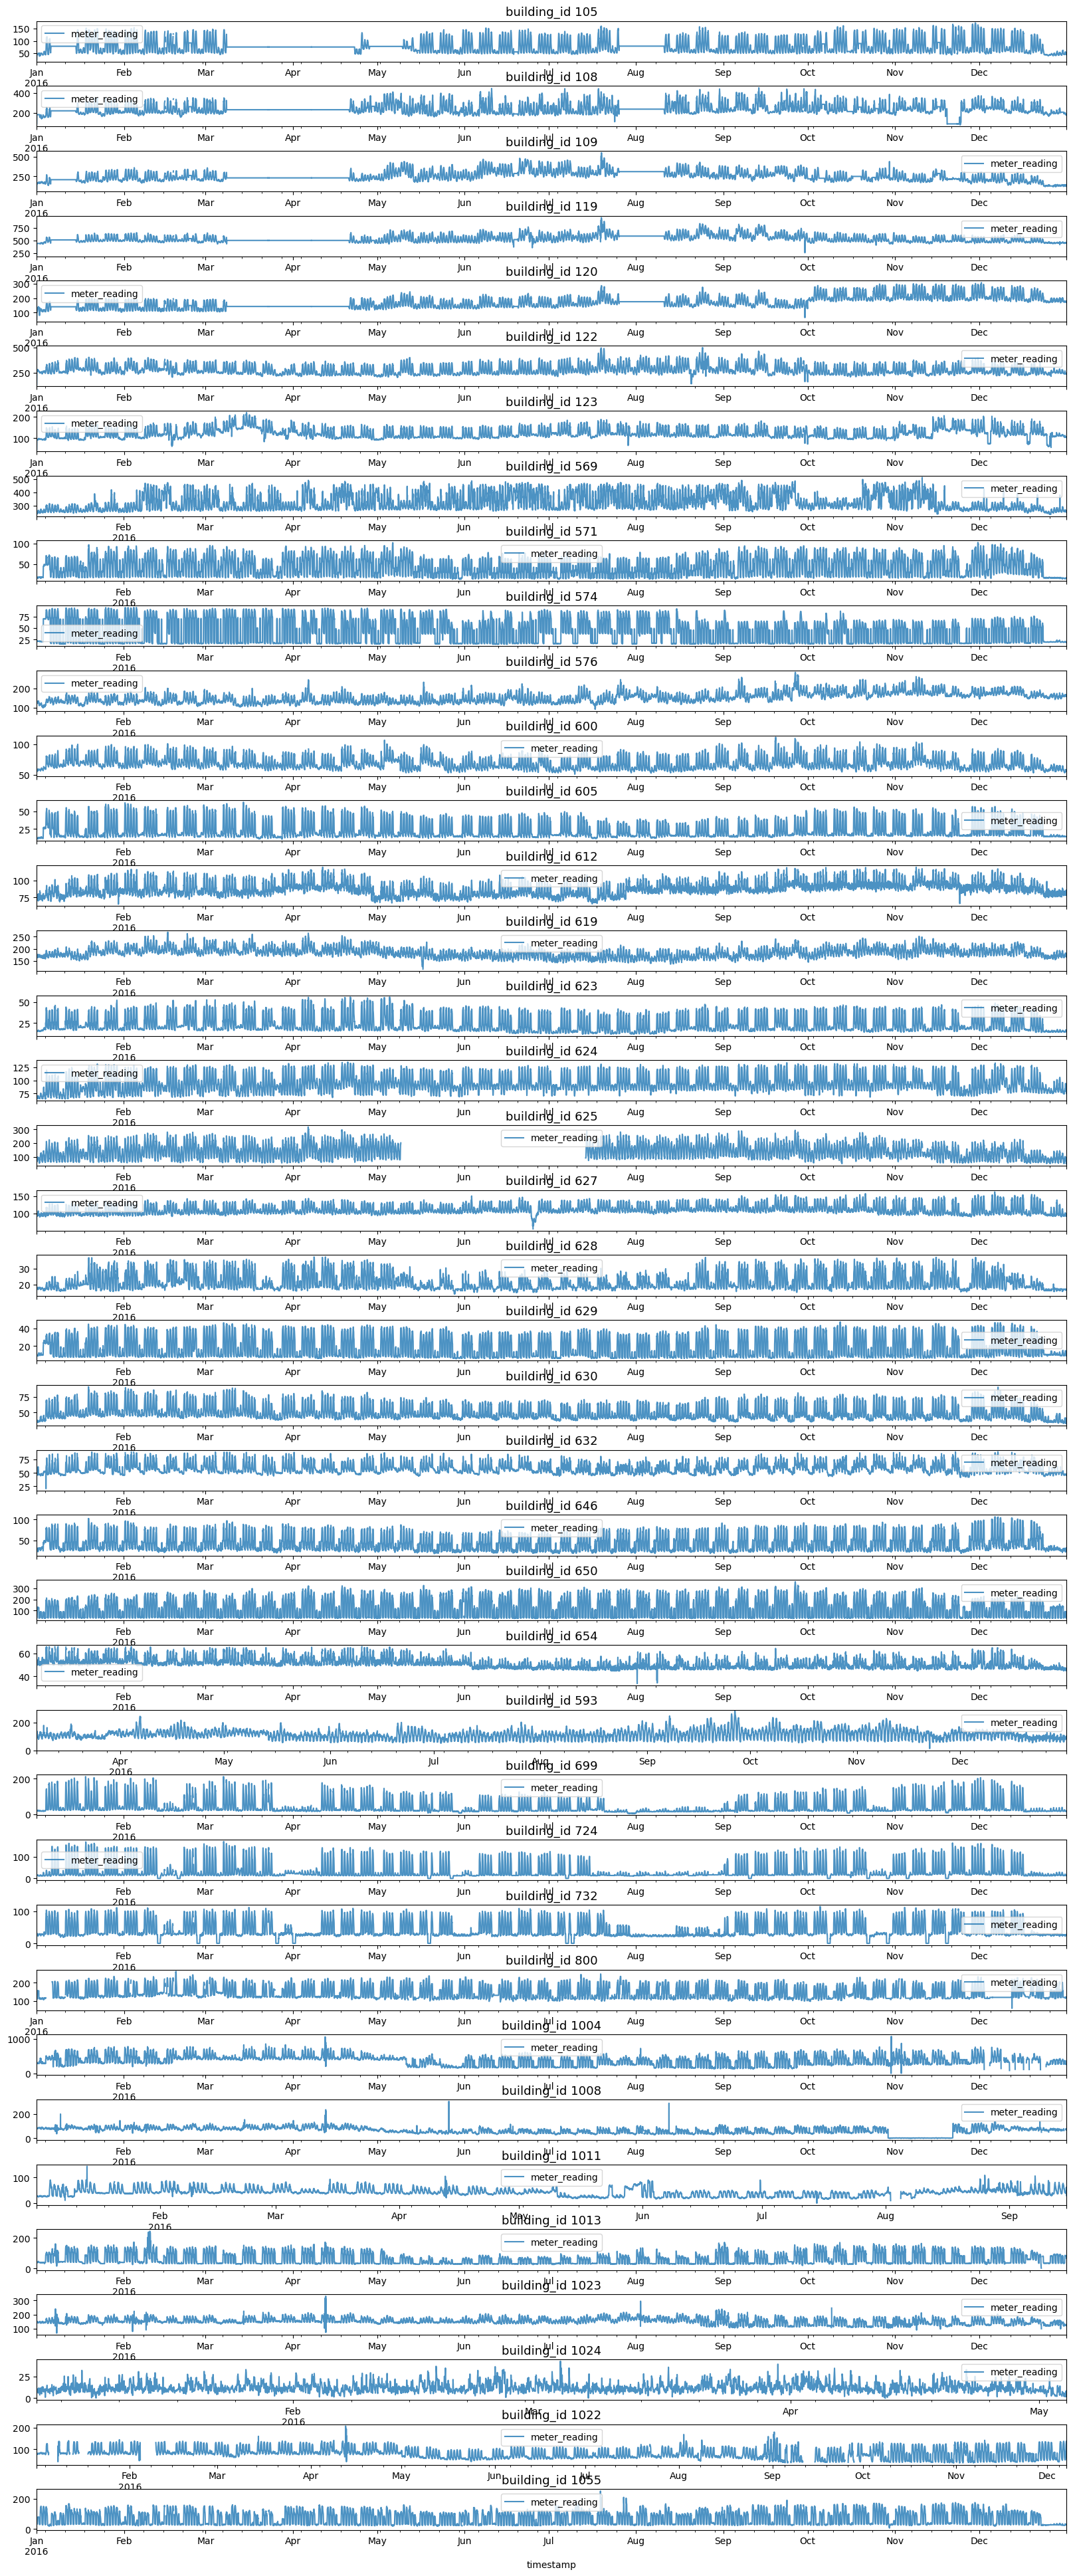

In [56]:
fig, axes = plt.subplots(39,figsize=(20, 50), dpi=100)
for ax,i in  enumerate(data['building_id'].unique()):
    try:
        data[data['building_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean().plot(ax=axes[ax], alpha=0.8, label='By hour')
        axes[ax].set_title('building_id {}'.format(i), fontsize=13);
        plt.subplots_adjust(hspace=0.6)
    except: pass